In [4]:
import pandas as pd, numpy as np

train_df = pd.read_csv('data/playground-series-s5e11/train.csv')
test_df = pd.read_csv('data/playground-series-s5e11/test.csv')
orig = pd.read_csv('data/playground-series-s5e11/loan_dataset_20000.csv')

print('Train Shape:', train_df.shape)
print('Test Shape:', test_df.shape)

Train Shape: (593994, 13)
Test Shape: (254569, 12)


In [7]:
train_df.head

<bound method NDFrame.head of             id  annual_income  debt_to_income_ratio  credit_score  \
0            0       29367.99                 0.084           736   
1            1       22108.02                 0.166           636   
2            2       49566.20                 0.097           694   
3            3       46858.25                 0.065           533   
4            4       25496.70                 0.053           665   
...        ...            ...                   ...           ...   
593989  593989       23004.26                 0.152           703   
593990  593990       35289.43                 0.105           559   
593991  593991       47112.64                 0.072           675   
593992  593992       76748.44                 0.067           740   
593993  593993       48959.52                 0.096           752   

        loan_amount  interest_rate  gender marital_status education_level  \
0           2528.42          13.67  Female         Single     Hi

In [5]:
TARGET = 'loan_paid_back'  #boolean
CATS = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
BASE = [col for col in train_df.columns if col not in ['id', TARGET]]

train = train_df.copy()
test = test_df.copy()

In [6]:
ORIG = []

for col in BASE:
    mean_map = orig.groupby(col)[TARGET].mean()
    new_mean_col_name = f"orig_mean_{col}"
    mean_map.name = new_mean_col_name
    
    train = train.merge(mean_map, on=col, how='left')
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(new_mean_col_name)

    new_count_col_name = f"orig_count_{col}"
    count_map = orig.groupby(col).size().reset_index(name=new_count_col_name)
    
    train = train.merge(count_map, on=col, how='left')
    test = test.merge(count_map, on=col, how='left')
    ORIG.append(new_count_col_name)

print(len(ORIG), 'Orig Features Created!!')

FEATURES = BASE + ORIG
print(len(FEATURES), 'Total Features.')

22 Orig Features Created!!
33 Total Features.


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train[FEATURES], train[TARGET].astype(int), 
    test_size=0.2, random_state=42, stratify=train[TARGET]
)

print(f'Train split (with ORIG features): {X_train.shape}')
print(f'Val split (with ORIG features): {X_val.shape}')

Train split (with ORIG features): (475195, 33)
Val split (with ORIG features): (118799, 33)


In [10]:
# numeric correlations
numeric_cols = train[BASE].select_dtypes(include=[np.number]).columns.tolist()
numeric_corr = pd.Series(dtype=float)
if numeric_cols:
    numeric_corr = train[numeric_cols].corrwith(train[TARGET].astype(int)).sort_values(ascending=False)

# categorical associations (Cramer's V)
cat_cols = [c for c in BASE if c not in numeric_cols]

# try to use scipy for chi2_contingency; fallback to a safe zero if unavailable
try:
    from scipy.stats import chi2_contingency
    def cramers_v(x, y):
        confusion = pd.crosstab(x, y)
        if confusion.size == 0:
            return 0.0
        chi2 = chi2_contingency(confusion)[0]
        n = confusion.sum().sum()
        if n == 0:
            return 0.0
        phi2 = chi2 / n
        r, k = confusion.shape
        # bias correction
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        denom = min((kcorr-1), (rcorr-1))
        return (phi2corr / denom)**0.5 if denom > 0 else 0.0
except Exception:
    def cramers_v(x, y):
        # fallback: compute association ratio by encoding categories to codes and using Pearson
        x_codes = x.astype('category').cat.codes
        return abs(x_codes.corr(y.astype(int)))

cat_assoc = {}
for c in cat_cols:
    col = train[c].fillna('NA')
    cat_assoc[c] = cramers_v(col, train[TARGET].astype(int))

cat_series = pd.Series(cat_assoc).sort_values(ascending=False)

# Display summaries
print('Numeric features (Pearson correlation with target):')
if not numeric_corr.empty:
    print(numeric_corr.to_string())
else:
    print('  No numeric features found in BASE.')

print('\nTop categorical associations (Cramer\'s V or fallback):')
if not cat_series.empty:
    print(cat_series.head(20).to_string())
else:
    print('  No categorical features found in BASE.')

# combined ranking by absolute strength
combined = pd.concat([
    numeric_corr.abs().rename('strength'),
    cat_series.abs().rename('strength')
]).sort_values(ascending=False)

print('\nTop features by absolute association strength with the target:')
print(combined.head(20).to_string())


Numeric features (Pearson correlation with target):
credit_score            0.234560
annual_income           0.006326
loan_amount            -0.003762
interest_rate          -0.131184
debt_to_income_ratio   -0.335680

Top categorical associations (Cramer's V or fallback):
employment_status    0.656820
grade_subgrade       0.227867
loan_purpose         0.025437
education_level      0.025274
gender               0.007202
marital_status       0.001375

Top features by absolute association strength with the target:
employment_status       0.656820
debt_to_income_ratio    0.335680
credit_score            0.234560
grade_subgrade          0.227867
interest_rate           0.131184
loan_purpose            0.025437
education_level         0.025274
gender                  0.007202
annual_income           0.006326
loan_amount             0.003762
marital_status          0.001375


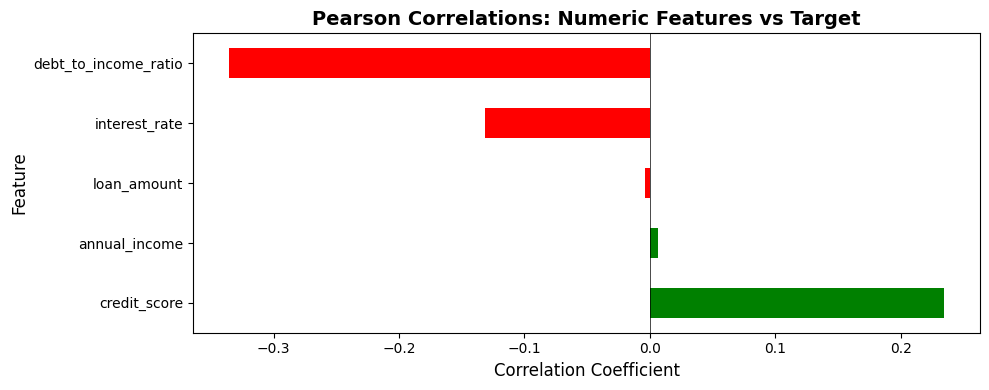

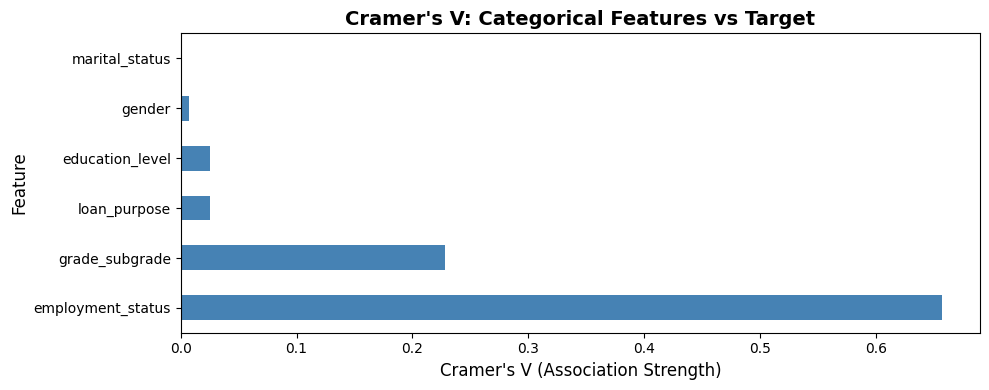

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Numeric correlations
if not numeric_corr.empty:
    fig, ax = plt.subplots(figsize=(10, max(4, len(numeric_corr) * 0.3)))
    numeric_corr.plot(kind='barh', ax=ax, color=['green' if x > 0 else 'red' for x in numeric_corr])
    ax.set_title('Pearson Correlations: Numeric Features vs Target', fontsize=14, fontweight='bold')
    ax.set_xlabel('Correlation Coefficient', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No numeric features to visualize.")

# Visualization 2: Categorical associations
if not cat_series.empty:
    fig, ax = plt.subplots(figsize=(10, max(4, len(cat_series) * 0.3)))
    cat_series.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title("Cramer's V: Categorical Features vs Target", fontsize=14, fontweight='bold')
    ax.set_xlabel("Cramer's V (Association Strength)", fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features to visualize.")

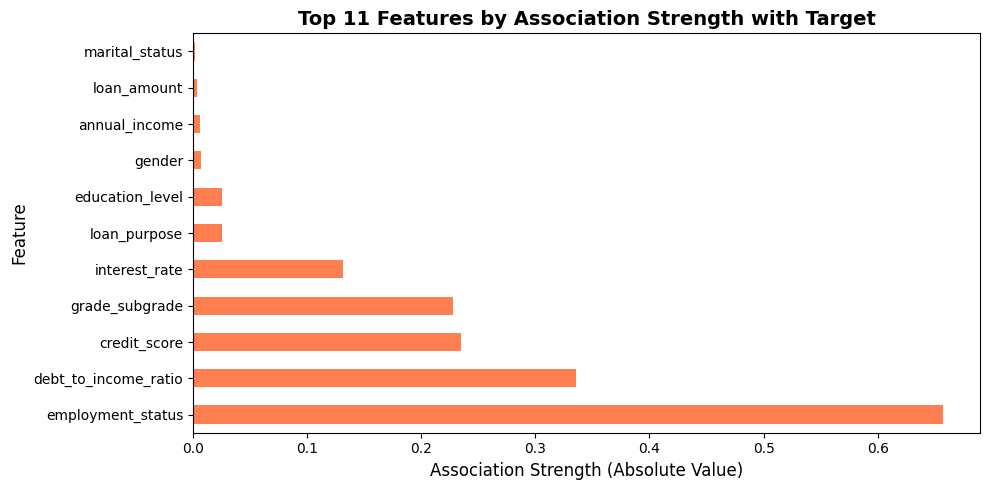

In [13]:
# Visualization 3: Combined importance 
if not combined.empty:
    fig, ax = plt.subplots(figsize=(10, max(5, len(combined) * 0.25)))
    top_n = min(20, len(combined))
    top_combined = combined.head(top_n)
    top_combined.plot(kind='barh', ax=ax, color='coral')
    ax.set_title(f'Top {top_n} Features by Association Strength with Target', fontsize=14, fontweight='bold')
    ax.set_xlabel('Association Strength (Absolute Value)', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No features to visualize.")

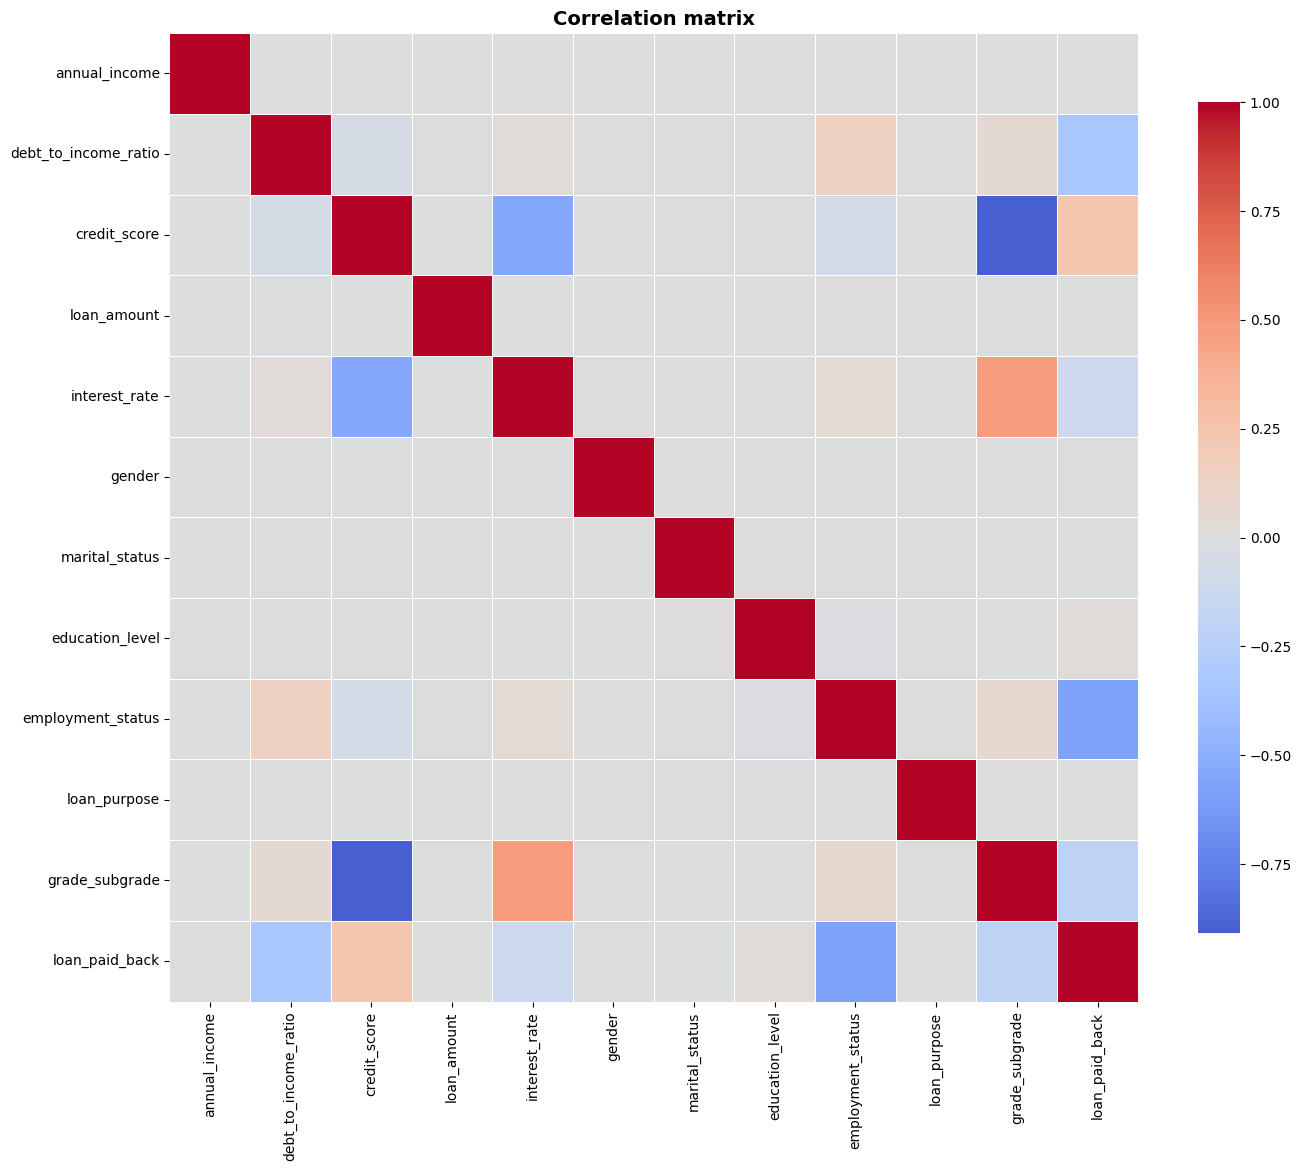


loan_paid_back in correlation (label encoded):
loan_paid_back          1.000000
credit_score            0.234560
education_level         0.018781
annual_income           0.006326
marital_status         -0.000404
loan_purpose           -0.000973
loan_amount            -0.003762
gender                 -0.007356
interest_rate          -0.131184
grade_subgrade         -0.212376
debt_to_income_ratio   -0.335680
employment_status      -0.585304


In [14]:
from sklearn.preprocessing import LabelEncoder

train_encoded = train[BASE].copy()

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_encoded[col] = le.fit_transform(train[col].fillna('NA'))
    le_dict[col] = le

train_encoded[TARGET] = train[TARGET].astype(int)

corr_matrix = train_encoded.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

target_corr = corr_matrix[TARGET].sort_values(ascending=False)
print(f'\n{TARGET} in correlation (label encoded):')
print(target_corr.to_string())

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# preprocess function
def preprocess_features(df, features, cat_cols, numeric_cols):
    """Prepare Categoric and Numerical Features"""
    df_processed = df[features].copy()
    
    # Kategorik kolonlar
    for col in cat_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna('NA').astype('category')
    
    # Numeric kolonlar
    for col in numeric_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(0)
    
    return df_processed

# select numerical colons
numeric_cols_full = [col for col in FEATURES if col not in cat_cols]

print(f'Total features: {len(FEATURES)}')
print(f'  - BASE features: {len(BASE)}')
print(f'  - ORIG features: {len(ORIG)}')
print(f'Numeric features: {len(numeric_cols_full)}')
print(f'Categorical features: {len(cat_cols)}')


X_train_full = preprocess_features(train, FEATURES, cat_cols, numeric_cols_full)
y_train_full = train[TARGET].astype(int)

X_test = preprocess_features(test, FEATURES, cat_cols, numeric_cols_full)

X_train_split = preprocess_features(X_train, FEATURES, cat_cols, numeric_cols_full)
X_val_split = preprocess_features(X_val, FEATURES, cat_cols, numeric_cols_full)

print(f'\nTraining set: {X_train_full.shape}')
print(f'Test set: {X_test.shape}')
print(f'Train split: {X_train_split.shape}')
print(f'Val split: {X_val_split.shape}')

# XGBoost model parameters
xgb_params = {
    'n_estimators': 10000,
    'max_depth': 4,
    'learning_rate': 0.010433357477511243,
    'tree_method': 'hist',
    'device': 'cpu',
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 42,
    'min_child_weight': 20,
    'subsample': 0.8879829126651821,
    'colsample_bytree': 0.5543148418738543,
    'gamma': 0.6845363006652688,
    'reg_alpha': 0.2399421158144976,
    'reg_lambda': 0.28254661049782354,
    'enable_categorical': True,
    'early_stopping_rounds': 100,
}

# Train XGBoost model
print('\nXGBoost training contuinue...')
model = XGBClassifier(**xgb_params)

model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_split, y_train), (X_val_split, y_val)],
    verbose=1000
)

print('Model training completed!')

# Predict on test set
pred = model.predict_proba(X_test)[:, 1]

# Prepare submission
submission = pd.DataFrame({
    "id": test["id"],
    TARGET: pred
})


# Save submission file
submission.to_csv("submission.csv", index=False)
print(f'\nSubmission file saved!: submission.csv')
print(f'Submission shape: {submission.shape}')
submission.head()

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/taha/Projects/langchain-course/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <636BF463-1886-392D-B8B3-6011C44DCEE9> /Users/taha/Projects/langchain-course/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/Users/taha/.pyenv/versions/3.12.6/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/taha/.pyenv/versions/3.12.6/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/Users/taha/.pyenv/versions/3.12.6/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/taha/.pyenv/versions/3.12.6/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file)"]
